In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


# Setup

## Transducer

In [4]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


## Domain

In [48]:
# define spatial domain
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
extent = N * dx # grid size [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]
print(f"Number of grid points: {N}\nGrid size: {extent} m\nGrid spacing: {dx} m")
assert transducer_extent < extent[0] - 2*pml[0]*dx[0], "Transducer extent is larger than grid size"

from jwave.geometry import Domain
domain = Domain((N[0],N[1]), (dx[0], dx[1]))

Number of grid points: [128 128]
Grid size: [0.03776 0.03776] m
Grid spacing: [0.000295 0.000295] m


In [49]:
# define transducer positions in spatial domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

from jwave.geometry import Sensors
sensors = Sensors(positions=(element_positions[0], element_positions[1]))

## Acoustic medium

In [50]:
np.random.seed(28)

# define reference properties
c0 = 1500 # reference speed of sound [m/s]
rho0 = 1000 # reference density [kg/m^3]

# define a random distribution of scatterers for the medium
background_map_mean = 1
background_map_std = 0.008
background_map = background_map_mean + background_map_std * np.random.randn(N[0], N[1])
sound_speed = c0 * np.ones(N) * background_map
density = rho0 * np.ones(N) * background_map

# define highly scattering region
scatterer_radius = 2 # radius of scatterers [grid points]
scatterer_contrast = 1.1 # contrast of scatterers
scatterer_positions = np.array([[N[0]//2, N[1]//2]], dtype=int)
scatterer_map = np.zeros(N)
x, y = np.ogrid[:N[0], :N[1]]
for scatterer_position in scatterer_positions:
    scatterer_map[(x - scatterer_position[0])**2 + (y - scatterer_position[1])**2 <= (scatterer_radius)**2] = 1
sound_speed[scatterer_map == 1] = c0*scatterer_contrast
density[scatterer_map == 1] = rho0*scatterer_contrast

# define medium
from jwave import FourierSeries
from jwave.geometry import Medium
sound_speed = FourierSeries(np.expand_dims(sound_speed, -1), domain)
density = FourierSeries(np.expand_dims(density, -1), domain)
medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=pml[0])
print(medium)


Medium[jaxdf.discretization.FourierSeries](
  domain=Domain(
    N=(np.int64(128), np.int64(128)),
    dx=(np.float64(0.000295), np.float64(0.000295))
  ),
  sound_speed=FourierSeries(
    params=f64[128,128,1](numpy),
    domain=Domain(
      N=(np.int64(128), np.int64(128)),
      dx=(np.float64(0.000295), np.float64(0.000295))
    )
  ),
  density=FourierSeries(
    params=f64[128,128,1](numpy),
    domain=Domain(
      N=(np.int64(128), np.int64(128)),
      dx=(np.float64(0.000295), np.float64(0.000295))
    )
  ),
  attenuation=1.0,
  pml_size=np.int64(20)
)


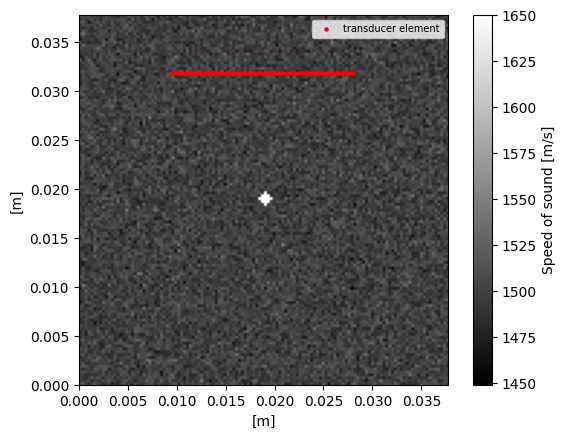

In [51]:
ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[0]*dx[0], element_positions[1]*dx[1],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(sound_speed.params, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})  # Decreased the size of the legend
plt.gca().invert_yaxis()
plt.show()

## Time

In [52]:
from jwave.geometry import TimeAxis

time_axis = TimeAxis.from_medium(medium, cfl=0.3)

## Source

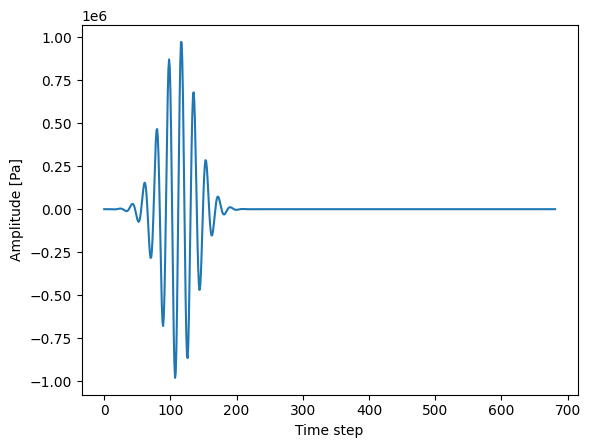

In [53]:
from jwave.signal_processing import gaussian_window

t = jnp.arange(0, time_axis.t_end, time_axis.dt)
s = transducer_magnitude * jnp.sin(2 * jnp.pi * transducer_frequency * t)
variance = 2/transducer_frequency
mean = 3*variance
s = gaussian_window(s, t, mean, variance)

plt.plot(s)
plt.xlabel('Time step')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [67]:
tuple(map(tuple, element_positions.T))

((np.int64(32), np.int64(108)),
 (np.int64(33), np.int64(108)),
 (np.int64(34), np.int64(108)),
 (np.int64(35), np.int64(108)),
 (np.int64(36), np.int64(108)),
 (np.int64(37), np.int64(108)),
 (np.int64(38), np.int64(108)),
 (np.int64(39), np.int64(108)),
 (np.int64(40), np.int64(108)),
 (np.int64(41), np.int64(108)),
 (np.int64(42), np.int64(108)),
 (np.int64(43), np.int64(108)),
 (np.int64(44), np.int64(108)),
 (np.int64(45), np.int64(108)),
 (np.int64(46), np.int64(108)),
 (np.int64(47), np.int64(108)),
 (np.int64(48), np.int64(108)),
 (np.int64(49), np.int64(108)),
 (np.int64(50), np.int64(108)),
 (np.int64(51), np.int64(108)),
 (np.int64(52), np.int64(108)),
 (np.int64(53), np.int64(108)),
 (np.int64(54), np.int64(108)),
 (np.int64(55), np.int64(108)),
 (np.int64(56), np.int64(108)),
 (np.int64(57), np.int64(108)),
 (np.int64(58), np.int64(108)),
 (np.int64(59), np.int64(108)),
 (np.int64(60), np.int64(108)),
 (np.int64(61), np.int64(108)),
 (np.int64(62), np.int64(108)),
 (np.int

In [80]:
from jwave.geometry import Sources

# sources = Sources(
#     positions=tuple(map(tuple, element_positions.T)), #((28, 64), (32, 32)),
#     signals=s,
#     dt=time_axis.dt,
#     domain=domain,
# )

# sources = Sources(transmit_indices, transmit_signal,
#                           dt=self.time_axis.dt, domain=self.domain)

sources = Sources(
    positions=((28, 64), (32, 32)),
    signals=jnp.stack([s, s]),
    dt=time_axis.dt,
    domain=domain,
)

# Run simulation

In [85]:
from jwave.acoustics import simulate_wave_propagation

@jit
def compiled_simulator(sources):
    return simulate_wave_propagation(medium, time_axis, sources=sources, sensors=sensors)

In [86]:
pressure = compiled_simulator(sources)

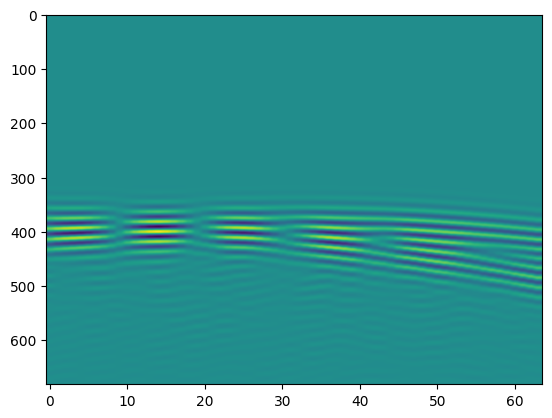

In [89]:
plt.imshow(np.squeeze(pressure), aspect='auto')
plt.show()



Text(0.5, 1.0, 'Pressure field at t=5.363636319088982e-06')

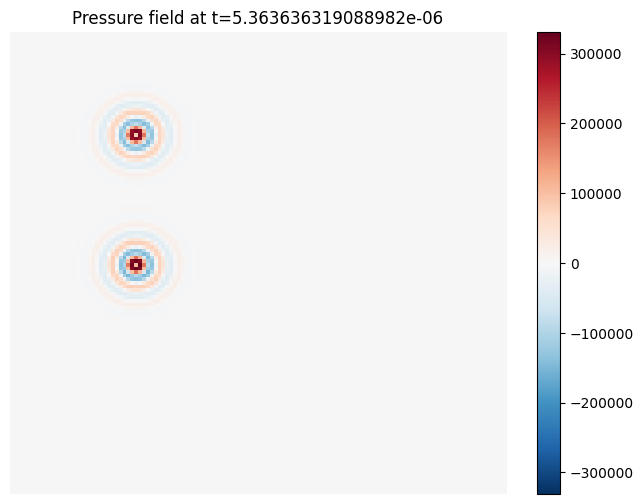

In [84]:
from jwave.utils import show_field

t = 100
show_field(pressure[t])
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")